## Configurations

### ADADRIFT

In [1]:
ADA_DEVIATION = 0.005
ADA_S_WINDOW = 1000

### General Configurations

In [24]:
CONFIDENCE = 0.95
GRACE_PERIOD = 0.1

## Experiments

In [3]:
def get_models(df):
    """Return all models in the application dataset

    Args:
        df (pd.DataFrame): Dataset containing probabilities and labels
    """
    models = [c.replace('prob_', '') for c in df.columns if 'prob_' in c]
    return models

In [30]:
from rto.protocols import ContinuousReevaluation
from rto.models import LogisticADADRIFT
import pandas as pd

DATA_FOLDER = '../data/'
data_paths = ['custom/application_01.feather', 'custom/application_02.feather', 'custom/application_03.feather', 'custom/application_04.feather']
# data_paths = ['synthetic/sea_v0_v1.feather', 'synthetic/mixed_recurrent.feather']
# data_paths = ['real/elec2.feather', 'real/airlines.feather']


OUT_FOLDER = '../output/'

for path in data_paths:
    print('Working on {}'.format(path.replace('.feather', '')))
    df = pd.read_feather(DATA_FOLDER + path)
    df = df.sort_values(by='timestamp')
    print(f'Loaded data: {df.shape}')

    streamer = LogisticADADRIFT(
                    s_window=ADA_S_WINDOW, 
                    confidence=CONFIDENCE, 
                    deviation=ADA_DEVIATION)
                    
    models = get_models(df)
    print(f'Evaluating models: {models}')
    evaluator = ContinuousReevaluation(streamer, models=models, delay_s=3600)

    n_samples = df.shape[0]
    n_train = int(n_samples * GRACE_PERIOD)

    train_set = df.iloc[:n_train, :]
    test_set = df.iloc[n_train:, :]

    print(f'Training set: {train_set.shape}')
    print(f'Test set: {test_set.shape}')

    evaluator.fit(train_set)
    result = evaluator.evaluate(test_set)
    result.to_feather(OUT_FOLDER + path)
    print()

Working on custom/application_01
Loaded data: (73865, 9)
Evaluating models: ['model_1', 'model_1_rev', 'model_2_rev', 'model_2']
Training set: (7386, 9)
Test set: (66479, 9)
Fit validation started..
Validating models ['model_1', 'model_1_rev', 'model_2_rev', 'model_2']
Updating model with training instances..


100%|██████████| 7386/7386 [00:00<00:00, 13328.57it/s]


Prequential evaluation started...


100%|██████████| 66479/66479 [00:07<00:00, 9180.60it/s]



Working on custom/application_02
Loaded data: (928587, 13)
Evaluating models: ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Training set: (92858, 13)
Test set: (835729, 13)
Fit validation started..
Validating models ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Updating model with training instances..


100%|██████████| 92858/92858 [00:08<00:00, 10663.00it/s]


Prequential evaluation started...


100%|██████████| 835729/835729 [02:31<00:00, 5508.49it/s]



Working on custom/application_03
Loaded data: (109674, 13)
Evaluating models: ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Training set: (10967, 13)
Test set: (98707, 13)
Fit validation started..
Validating models ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Updating model with training instances..


100%|██████████| 10967/10967 [00:01<00:00, 7488.42it/s]


Prequential evaluation started...


100%|██████████| 98707/98707 [00:17<00:00, 5574.95it/s]



Working on custom/application_04
Loaded data: (319701, 13)
Evaluating models: ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Training set: (31970, 13)
Test set: (287731, 13)
Fit validation started..
Validating models ['model_1', 'model_1_rev', 'model_2_rev', 'model_2', 'model_3', 'model_4']
Updating model with training instances..


100%|██████████| 31970/31970 [00:03<00:00, 8710.25it/s]


Prequential evaluation started...


100%|██████████| 287731/287731 [00:49<00:00, 5774.14it/s]


## Evaluate Performance

In [27]:
def rename_model(model_name):
    model_name = model_name.replace('model_', 'M')
    model_name = model_name.replace('_rev', 'R')
    model_name = model_name if 'R' in model_name else model_name + ' '
    return model_name

Working on elec2
Loaded data: (28548, 11)
Evaluating models: ['negative', 'positive']
Automatic negative: 0.00%
Positive Predictive Value negative: 0.00%
Automatic positive: 0.00%
Positive Predictive Value positive: 0.00%


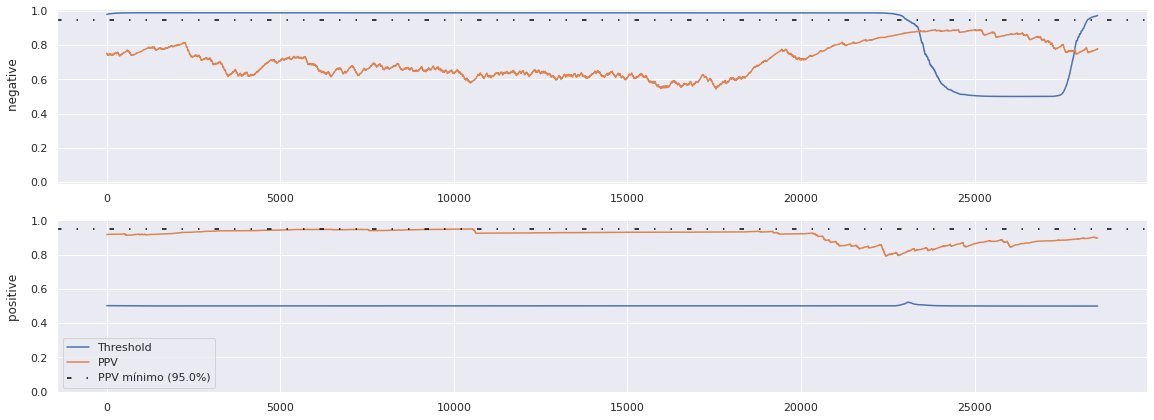

Working on airlines
Loaded data: (339813, 11)
Evaluating models: ['negative', 'positive']
Automatic negative: 0.00%
Positive Predictive Value negative: 0.00%
Automatic positive: 0.00%
Positive Predictive Value positive: 0.00%


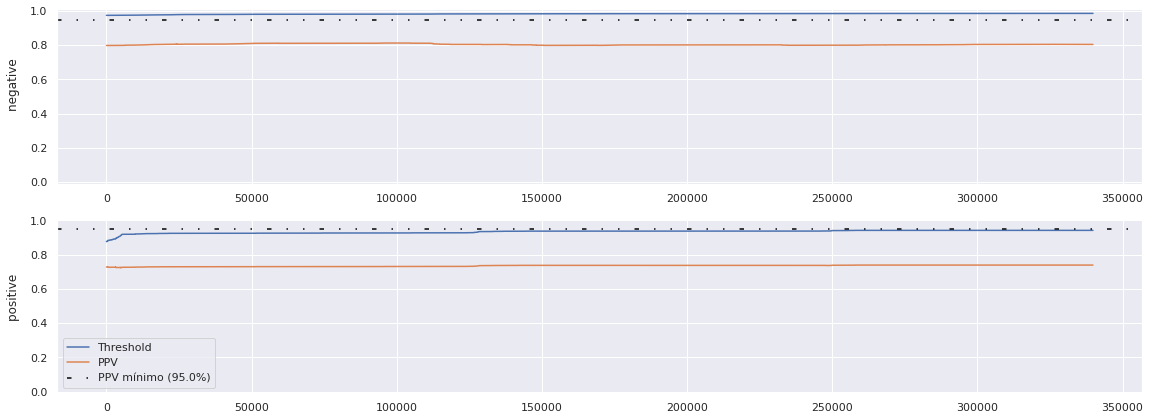

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

OUT_FOLDER = '../output/'
# data_paths = ['custom/application_01.feather', 'custom/application_02.feather', 'custom/application_03.feather', 'custom/application_04.feather']
# data_paths = ['synthetic/sea_v0_v1.feather', 'synthetic/mixed_recurrent.feather']
data_paths = ['real/elec2.feather', 'real/airlines.feather']



for path in data_paths:
    application = path.split('/')[-1].replace('.feather', '')
    print('Working on {}'.format(application))
    df = pd.read_feather(OUT_FOLDER + path)
    df = df.sort_values(by='timestamp')
    print(f'Loaded data: {df.shape}')

    models = get_models(df)
    print(f'Evaluating models: {models}')
    sns.set()
    f = plt.figure(figsize=(16,3 * len(models)))
    plt.title(f'{application}')
    for index, model in enumerate(models):

        automatic_ratio = df[f'auto_{model}'].mean()*100
        ppv_ratio = df[df[f'auto_{model}'].astype(bool)][f'label_{model}'].mean()*100
        automatic_ratio = automatic_ratio if not math.isnan(automatic_ratio) else 0.0
        ppv_ratio = ppv_ratio if not math.isnan(ppv_ratio) else 0.0
        
        print('Automatic {}: {:.2f}%'.format(model, automatic_ratio))
        print('Positive Predictive Value {}: {:.2f}%'.format(model, ppv_ratio))
        ax = plt.subplot(len(models), 1, index+1)
        try:
            plt.plot(df[f'ths_{model}'], label='Threshold')
            plt.plot(df[f'err_{model}'], label='PPV')
        except KeyError as e:
            print(df.columns)
            exit()
        acc_baseline = CONFIDENCE - ADA_DEVIATION 
        plt.axhline(y=CONFIDENCE, linestyle=(0, (3, 10, 1, 10, 1, 10)), color='black', label='PPV mínimo ({}%)'.format(CONFIDENCE * 100))
        plt.title(f'{rename_model(model)}', rotation='vertical',x=-0.04,y=0.4)
        plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.legend()
    plt.show()